In [107]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import functools
import plotly.express as px
spark = SparkSession.builder.appName("Chicago_crime_analysis").getOrCreate()

In [108]:
from pyspark.sql.types import  (StructType, 
                                StructField, 
                                DateType, 
                                BooleanType,
                                DoubleType,
                                IntegerType,
                                StringType,
                               TimestampType)
crimes_schema = StructType([
                            StructField(" ", StringType(), True),
                            StructField("ID", StringType(), True),
                            StructField("CaseNumber", StringType(), True),
                            StructField("Date", StringType(), True ),
                            StructField("Block", StringType(), True),
                            StructField("IUCR", StringType(), True),
                            StructField("PrimaryType", StringType(), True  ),
                            StructField("Description", StringType(), True ),
                            StructField("LocationDescription", StringType(), True ),
                            StructField("Arrest", BooleanType(), True),
                            StructField("Domestic", BooleanType(), True),
                            StructField("Beat", StringType(), True),
                            StructField("District", StringType(), True),
                            StructField("Ward", StringType(), True),
                            StructField("CommunityArea", StringType(), True),
                            StructField("FBICode", StringType(), True ),
                            StructField("XCoordinate", DoubleType(), True),
                            StructField("YCoordinate", DoubleType(), True ),
                            StructField("Year", IntegerType(), True),
                            StructField("UpdatedOn", DateType(), True ),
                            StructField("Latitude", DoubleType(), True),
                            StructField("Longitude", DoubleType(), True),
                            StructField("Location", StringType(), True )
                            ])

In [109]:
def __unionAll(dfs):
        return functools.reduce(lambda df1, df2: df1.union(df2.select(df1.columns)), dfs)

In [110]:
CC_0104 = spark.read.csv("data/Chicago_Crimes_2001_to_2004.csv", header = True, schema=crimes_schema)
CC_0507 = spark.read.csv("data/Chicago_Crimes_2005_to_2007.csv", header = True, schema=crimes_schema)
CC_0811 = spark.read.csv("data/Chicago_Crimes_2008_to_2011.csv", header = True, schema=crimes_schema)
CC_1217 = spark.read.csv("data/Chicago_Crimes_2012_to_2017.csv", header = True, schema=crimes_schema)
        
to_present = __unionAll([CC_0104, CC_0507, CC_0811, CC_1217])
print((to_present.count(), len(to_present.columns)))

to_present = to_present.where(col("XCoordinate").isNotNull())
to_present = to_present.where(col("Ward").isNotNull())
to_present = to_present.where(col("CommunityArea").isNotNull())
to_present = to_present.drop("ID", "Case Number", "IUCR", "FBI Code", "Location", "District", "Community Area")

(7941286, 23)


In [111]:
from pyspark.sql.functions import from_unixtime, unix_timestamp, col

CC_0104 = CC_0104.withColumn('Date', from_unixtime(unix_timestamp(col(('Date')), "MM/dd/yyyy hh:mm:ss a"), "yyyy-MM-dd HH:mm:ss"))
CC_0507 = CC_0507.withColumn('Date', from_unixtime(unix_timestamp(col(('Date')), "MM/dd/yyyy hh:mm:ss a"), "yyyy-MM-dd HH:mm:ss"))
CC_0811 = CC_0811.withColumn('Date', from_unixtime(unix_timestamp(col(('Date')), "MM/dd/yyyy hh:mm:ss a"), "yyyy-MM-dd HH:mm:ss"))
CC_1217 = CC_1217.withColumn('Date', from_unixtime(unix_timestamp(col(('Date')), "MM/dd/yyyy hh:mm:ss a"), "yyyy-MM-dd HH:mm:ss"))
to_present = to_present.withColumn('Date', from_unixtime(unix_timestamp(col(('Date')), "MM/dd/yyyy hh:mm:ss a"), "yyyy-MM-dd HH:mm:ss")) 

In [112]:
print((to_present.count(), len(to_present.columns)))

22/04/29 16:59:59 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Ward, Community Area, X Coordinate
 Schema: Ward, CommunityArea, XCoordinate
Expected: CommunityArea but found: Community Area
CSV file: file:///home/torhaca/chicago-crime-hadoop/data/Chicago_Crimes_2001_to_2004.csv
22/04/29 17:00:00 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Ward, Community Area, X Coordinate
 Schema: Ward, CommunityArea, XCoordinate
Expected: CommunityArea but found: Community Area
CSV file: file:///home/torhaca/chicago-crime-hadoop/data/Chicago_Crimes_2005_to_2007.csv
22/04/29 17:00:01 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Ward, Community Area, X Coordinate
 Schema: Ward, CommunityArea, XCoordinate
Expected: CommunityArea but found: Community Area
CSV file: file:///home/torhaca/chicago-crime-hadoop/data/Chicago_Crimes_2008_to_2011.csv
22/04/29 17:00:03 WARN CSVHeaderChecker: CSV header does not conform to t

(7146796, 19)


In [113]:
map_marks = to_present.limit(10000).toPandas()
map_marks[['Latitude', 'Longitude']]

22/04/29 17:00:04 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: NUM, Case Number, Date, Block, Primary Type, Description, Location Description, Arrest, Domestic, Beat, Ward, Community Area, FBI Code, X Coordinate, Y Coordinate, Year, Updated On, Latitude, Longitude
 Schema:  , CaseNumber, Date, Block, PrimaryType, Description, LocationDescription, Arrest, Domestic, Beat, Ward, CommunityArea, FBICode, XCoordinate, YCoordinate, Year, UpdatedOn, Latitude, Longitude
Expected:   but found: NUM
CSV file: file:///home/torhaca/chicago-crime-hadoop/data/Chicago_Crimes_2001_to_2004.csv


,Latitude,Longitude
0,41.817229,-87.637328
1,41.691785,-87.635116
2,41.687020,-87.608445
3,41.729712,-87.653159
4,41.869772,-87.708180
...,...,...
9995,41.840797,-87.642713
9996,41.769324,-87.571492
9997,41.882394,-87.627845
9998,41.864100,-87.713724


In [114]:
fig = px.scatter_mapbox(map_marks, lat="Latitude", lon="Longitude", 
                        color_discrete_sequence=["fuchsia"], zoom=9, height=650)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
d=to_present.limit(100000).toPandas().groupby("PrimaryType").sum()["Arrest"]
d

PrimaryType
ARSON                                 30
ASSAULT                             1597
BATTERY                             4688
BURGLARY                             351
CRIM SEXUAL ASSAULT                  105
CRIMINAL DAMAGE                      955
CRIMINAL TRESPASS                   1984
DECEPTIVE PRACTICE                   780
GAMBLING                             217
HOMICIDE                             819
INTERFERENCE WITH PUBLIC OFFICER      53
INTIMIDATION                           9
KIDNAPPING                            30
LIQUOR LAW VIOLATION                 308
MOTOR VEHICLE THEFT                  709
NARCOTICS                           9636
OBSCENITY                              7
OFFENSE INVOLVING CHILDREN           177
OTHER NARCOTIC VIOLATION               1
OTHER OFFENSE                       1073
PROSTITUTION                        1148
PUBLIC INDECENCY                       3
PUBLIC PEACE VIOLATION               213
ROBBERY                              322
SEX 

In [ ]:
import matplotlib.pyplot as plt # plotting

plt.style.use(plt.style.available[9])
plt.figure(figsize=(8,8))
plt.pie(
    to_present.limit(100000).toPandas().groupby("PrimaryType").sum()["Arrest"],
    labels=to_present.limit(100000).toPandas().groupby("PrimaryType").sum().index,
    radius=1, 
    autopct='%0.1f%%', )
    #explode=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
plt.title('test', fontdict={'fontsize': 16})
plt.show()

22/04/29 14:32:38 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: NUM, Case Number, Date, Block, Primary Type, Description, Location Description, Arrest, Domestic, Beat, Ward, Community Area, FBI Code, X Coordinate, Y Coordinate, Year, Updated On, Latitude, Longitude
 Schema:  , CaseNumber, Date, Block, PrimaryType, Description, LocationDescription, Arrest, Domestic, Beat, Ward, CommunityArea, FBICode, XCoordinate, YCoordinate, Year, UpdatedOn, Latitude, Longitude
Expected:   but found: NUM
CSV file: file:///home/torhaca/chicago-crime-hadoop/data/Chicago_Crimes_2001_to_2004.csv
22/04/29 14:32:45 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: NUM, Case Number, Date, Block, Primary Type, Description, Location Description, Arrest, Domestic, Beat, Ward, Community Area, FBI Code, X Coordinate, Y Coordinate, Year, Updated On, Latitude, Longitude
 Schema:  , CaseNumber, Date, Block, PrimaryType, Description, LocationDescription, Arrest, D

KeyboardInterrupt: 

<Figure size 576x1440 with 0 Axes>

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:708)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:752)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:662)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:628)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:604)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:561)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:518)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


In [ ]:
plt.show()

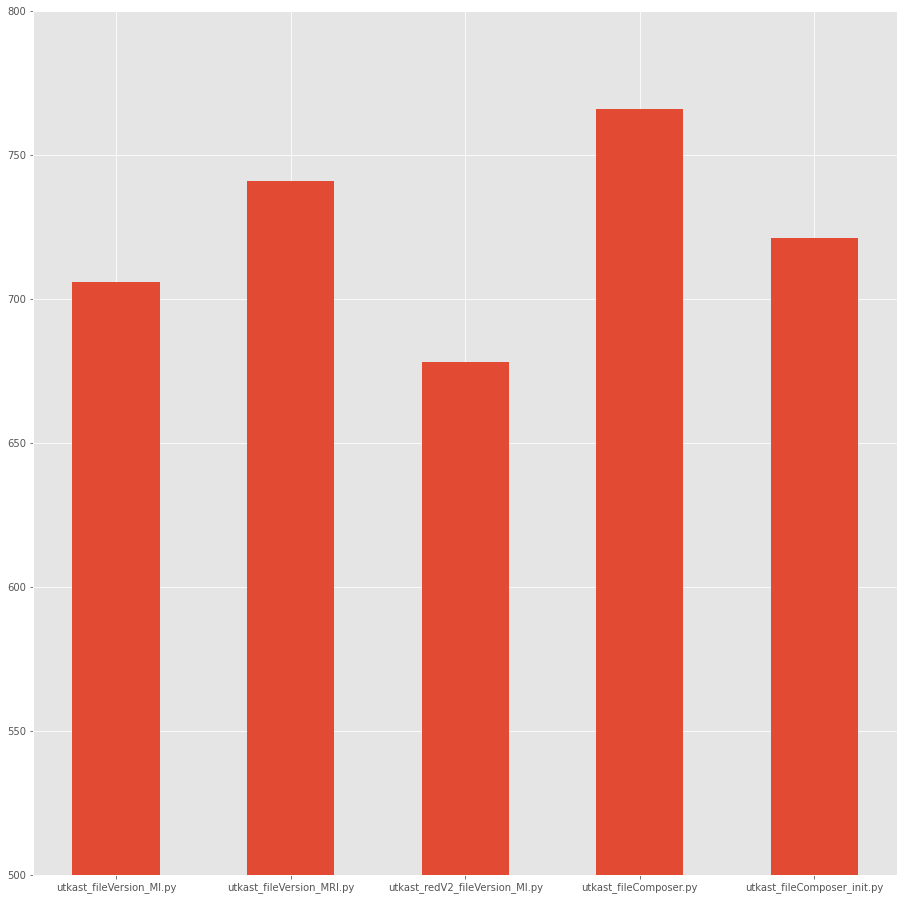

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,2,3])
# COMPARISON OF VERSIONS
# runtime = [1357, 
runtime = [706, 741, 678, 766, 721]
# versions = ["utkast_fileVersion.py",
versions = ["utkast_fileVersion_MI.py", "utkast_fileVersion_MRI.py",
"utkast_redV2_fileVersion_MI.py", "utkast_fileComposer.py", "utkast_fileComposer_init.py"]

# plt.bar(X_axis + 0.3, Thirteen, 0.2, label = 'Thirteen')
ax.bar(versions,runtime, 0.5)
ax.set(ylim=[500, 800])
plt.show()

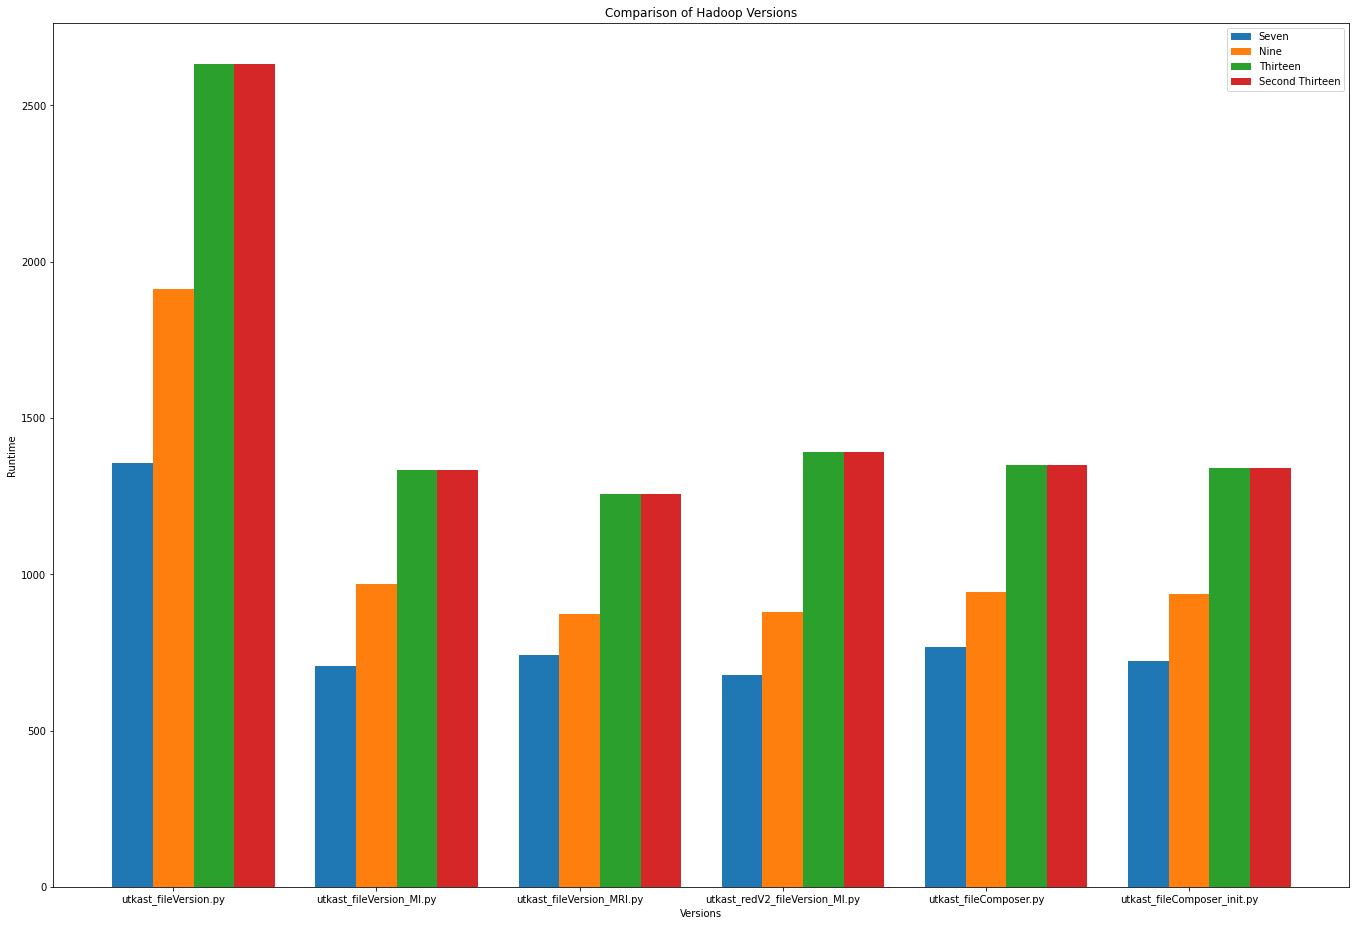

In [29]:
"""
import numpy as np 
import matplotlib.pyplot as plt

runtime = [[1357, 706, 741, 678, 766, 721],
[2632, 1332, 1258, 1392, 1348, 1339],
[2469, 1349, 1319, 1385, 1206, 1309]]
# versions = ["utkast_fileVersion.py",
versions ["utkast_fileVersion.py", "utkast_fileVersion_MI.py", "utkast_fileVersion_MRI.py",
"utkast_redV2_fileVersion_MI.py", "utkast_fileComposer.py", "utkast_fileComposer_init.py"]
V_x = np.arange(len(versions))

fig = plt.figure()
)
ax.bar(V_x+0.00, runtime[0], color = 'b', width=0.25)
ax.bar(V_x+0.25, runtime[1], color = 'g', width=0.25)
ax.bar(V_x+0.50, runtime[2], color = 'r', width=0.25)
plt.show()
"""
import numpy as np 
import matplotlib.pyplot as plt 

X = ["utkast_fileVersion.py", "utkast_fileVersion_MI.py", "utkast_fileVersion_MRI.py",
"utkast_redV2_fileVersion_MI.py", "utkast_fileComposer.py", "utkast_fileComposer_init.py"]

Spark = [39, 172, 63, 101]
Seven = [1357, 706, 741, 678, 766, 721]
Nine = [1914, 970, 874, 879, 942, 937]
Thirteen = [2632, 1332, 1258, 1392, 1348, 1339]
Thirteen2 = [2469, 1349, 1319, 1385, 1207, 1310]

# [,

fig = plt.figure()
X_axis = np.arange(len(X))
ax = fig.add_axes([0,0,3,3])
  
plt.bar(X_axis - 0.2, Seven, 0.2, label = 'Seven')
plt.bar(X_axis + 0.0, Nine, 0.2, label = 'Nine')
plt.bar(X_axis + 0.2, Thirteen, 0.2, label = 'Thirteen')
plt.bar(X_axis + 0.4, Thirteen, 0.2, label = 'Second Thirteen')
  
plt.xticks(X_axis, X)
plt.xlabel("Versions")
plt.ylabel("Runtime")
plt.title("Comparison of Hadoop Versions")
plt.legend()
plt.show()


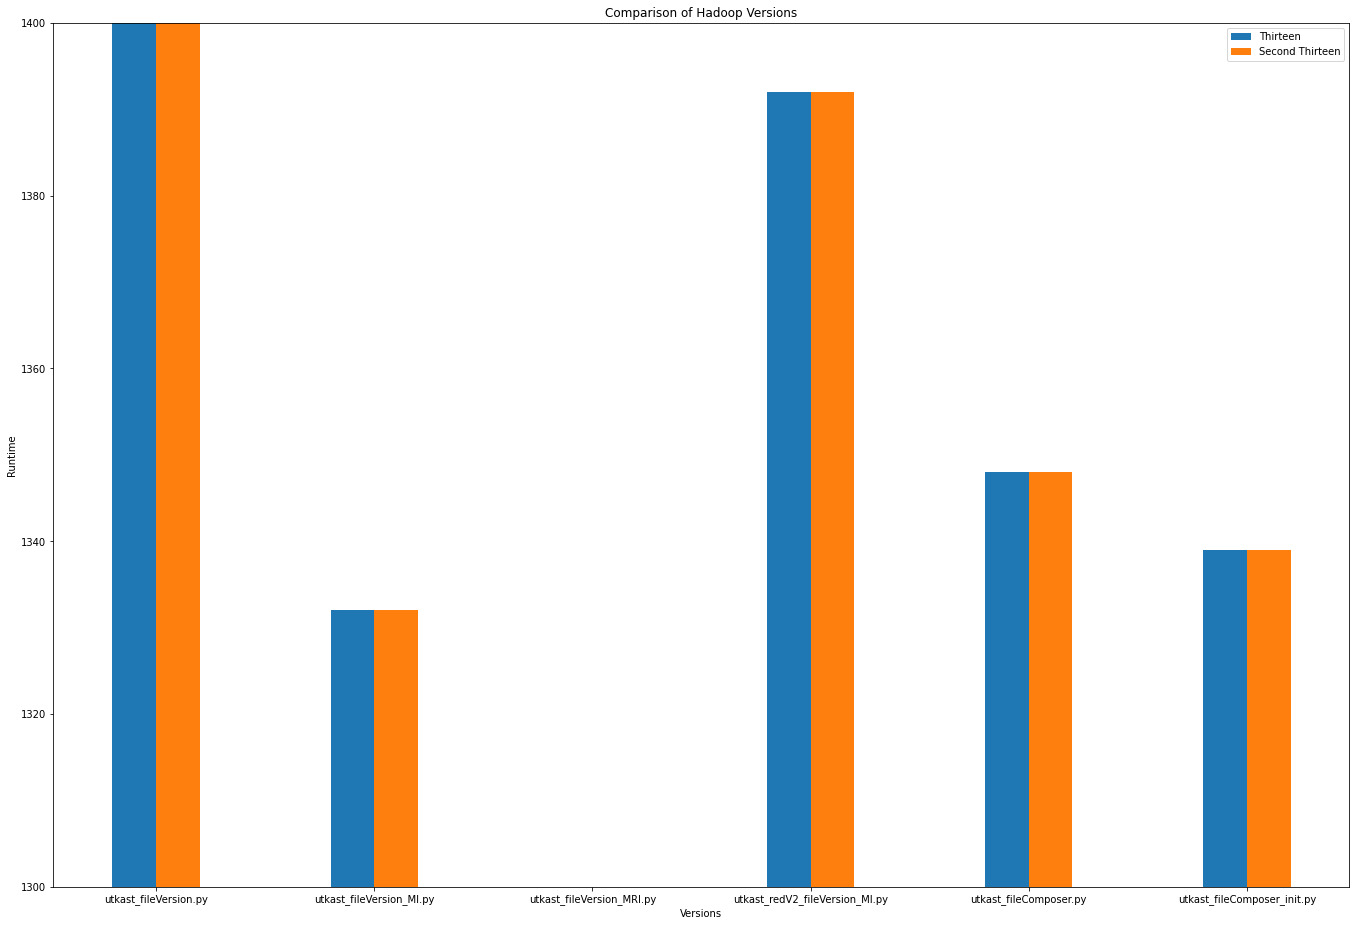

In [32]:
import numpy as np 
import matplotlib.pyplot as plt 

X = ["utkast_fileVersion.py", "utkast_fileVersion_MI.py", "utkast_fileVersion_MRI.py",
"utkast_redV2_fileVersion_MI.py", "utkast_fileComposer.py", "utkast_fileComposer_init.py"]

Thirteen = [2632, 1332, 1258, 1392, 1348, 1339]
Thirteen2 = [2469, 1349, 1319, 1385, 1207, 1310]

# [,

fig = plt.figure()
X_axis = np.arange(len(X))
ax = fig.add_axes([0,0,3,3])
ax.set(ylim=[1300, 1400])

plt.bar(X_axis - 0.1, Thirteen, 0.2, label = 'Thirteen')
plt.bar(X_axis + 0.1, Thirteen, 0.2, label = 'Second Thirteen')
  
plt.xticks(X_axis, X)
plt.xlabel("Versions")
plt.ylabel("Runtime")
plt.title("Comparison of Hadoop Versions")
plt.legend()
plt.show()

In [ ]:
# WORST RUN 54

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,2,3])
# COMPARISON OF VERSIONS
# runtime = [1357, 
runtime = [10464, 5362, 741, 678, 766, 721]
# versions = ["utkast_fileVersion.py",
versions = ["utkast_fileVersion_MI.py", "utkast_fileVersion_MRI.py",
"utkast_redV2_fileVersion_MI.py", "utkast_fileComposer.py", "utkast_fileComposer_init.py"]

# plt.bar(X_axis + 0.3, Thirteen, 0.2, label = 'Thirteen')
ax.bar(versions,runtime, 0.5)
ax.set(ylim=[500, 800])
plt.show()

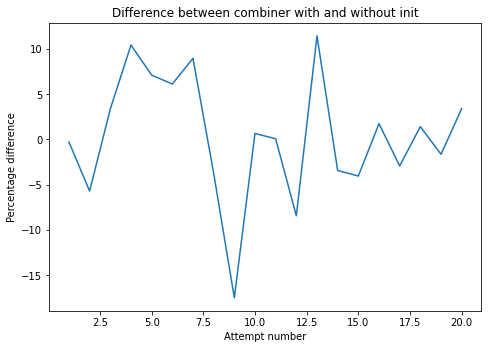

Combiner with or without initiator mean:  0.35066326824653515


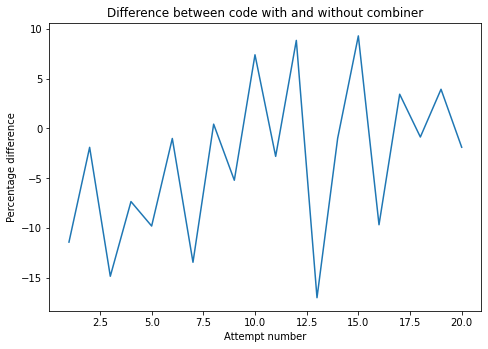

With or without combiner mean:  -3.243933155393736


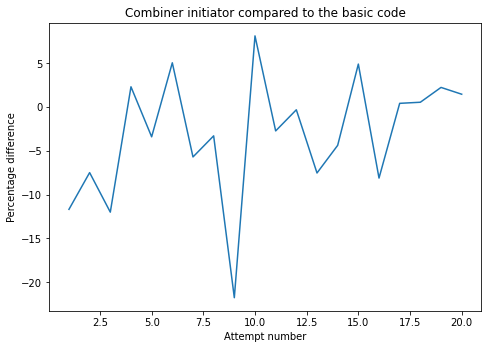

With or without combiner mean:  -3.1725321489339477


In [24]:
# COMBINER COMPARISON

# runtime before: 664520
# runtime after: 1060590

import matplotlib.pyplot as plt
import statistics

def difference(c, c_init):
    difference = []
    for i in range(len(c)):
        comb = c[i]
        comb_i = c_init[i]
        diff = ((comb_i/comb)*100) - 100
        difference.append(diff)
    return difference

with_without_combiner = []
total_difference = []
total_difference_CI = []

#           RUN 0
map_red_init = [779, 948, 1400, 1347]
combiner = [690, 930, 1192, 1248]
combiner_init = [688, 877, 1232, 1378]

total_difference.append(difference(combiner, combiner_init))
with_without_combiner.append(difference(map_red_init, combiner))
total_difference_CI.append(difference(map_red_init, combiner_init))

#           RUN 1
map_red_init = [734, 893, 1420, 1395]
combiner = [662, 884, 1229, 1401]
combiner_init = [709, 938, 1339, 1349]

total_difference.append(difference(combiner, combiner_init))
with_without_combiner.append(difference(map_red_init, combiner))
total_difference_CI.append(difference(map_red_init, combiner_init))

#           RUN 2
map_red_init = [749, 851, 1390, 1243]
combiner = [710, 914, 1351, 1353]
combiner_init = [586, 920, 1352, 1239]

total_difference.append(difference(combiner, combiner_init))
with_without_combiner.append(difference(map_red_init, combiner))
total_difference_CI.append(difference(map_red_init, combiner_init))

#           RUN 3
map_red_init = [770, 913, 1247, 1405]
combiner = [639, 904, 1363, 1269]
combiner_init = [712, 873, 1308, 1291]

total_difference.append(difference(combiner, combiner_init))
with_without_combiner.append(difference(map_red_init, combiner))
total_difference_CI.append(difference(map_red_init, combiner_init))

#           RUN 4
map_red_init = [727, 929, 1346, 1376]
combiner = [752, 921, 1399,  1350] # 5]
combiner_init = [730, 934, 1376, 1396]

total_difference.append(difference(combiner, combiner_init))
with_without_combiner.append(difference(map_red_init, combiner))
total_difference_CI.append(difference(map_red_init, combiner_init))

def find_singledifference(total_d):
    single_list_diff = []
    attempts = []
    attempt = 1
    for i in total_d:
        for diff in i:
            single_list_diff.append(diff)
            attempts.append(attempt)
            attempt += 1
    return single_list_diff, attempts

single_list_diff, attempts = find_singledifference(total_difference)

x = statistics.mean(single_list_diff)
 
# Printing the mean

fig = plt.figure()
fig.add_axes([0,0,1,1])
plt.plot(attempts, single_list_diff)
plt.xlabel('Attempt number')
plt.ylabel('Percentage difference')
plt.title("Difference between combiner with and without init")
plt.show()
print("Combiner with or without initiator mean: ", x)

single_list_without_combiner, attempts = find_singledifference(with_without_combiner)
x = statistics.mean(single_list_without_combiner)

fig = plt.figure()
fig.add_axes([0,0,1,1])
plt.plot(attempts, single_list_without_combiner)
plt.xlabel('Attempt number')
plt.ylabel('Percentage difference')
plt.title("Difference between code with and without combiner")
plt.show()
print("With or without combiner mean: ", x)

single_BAsic_to_CI_cmparison, attempts = find_singledifference(total_difference_CI)
x = statistics.mean(single_BAsic_to_CI_cmparison)

fig = plt.figure()
fig.add_axes([0,0,1,1])
plt.plot(attempts, single_BAsic_to_CI_cmparison)
plt.xlabel('Attempt number')
plt.ylabel('Percentage difference')
plt.title("Combiner initiator compared to the basic code")
plt.show()
print("With or without combiner mean: ", x)





# """

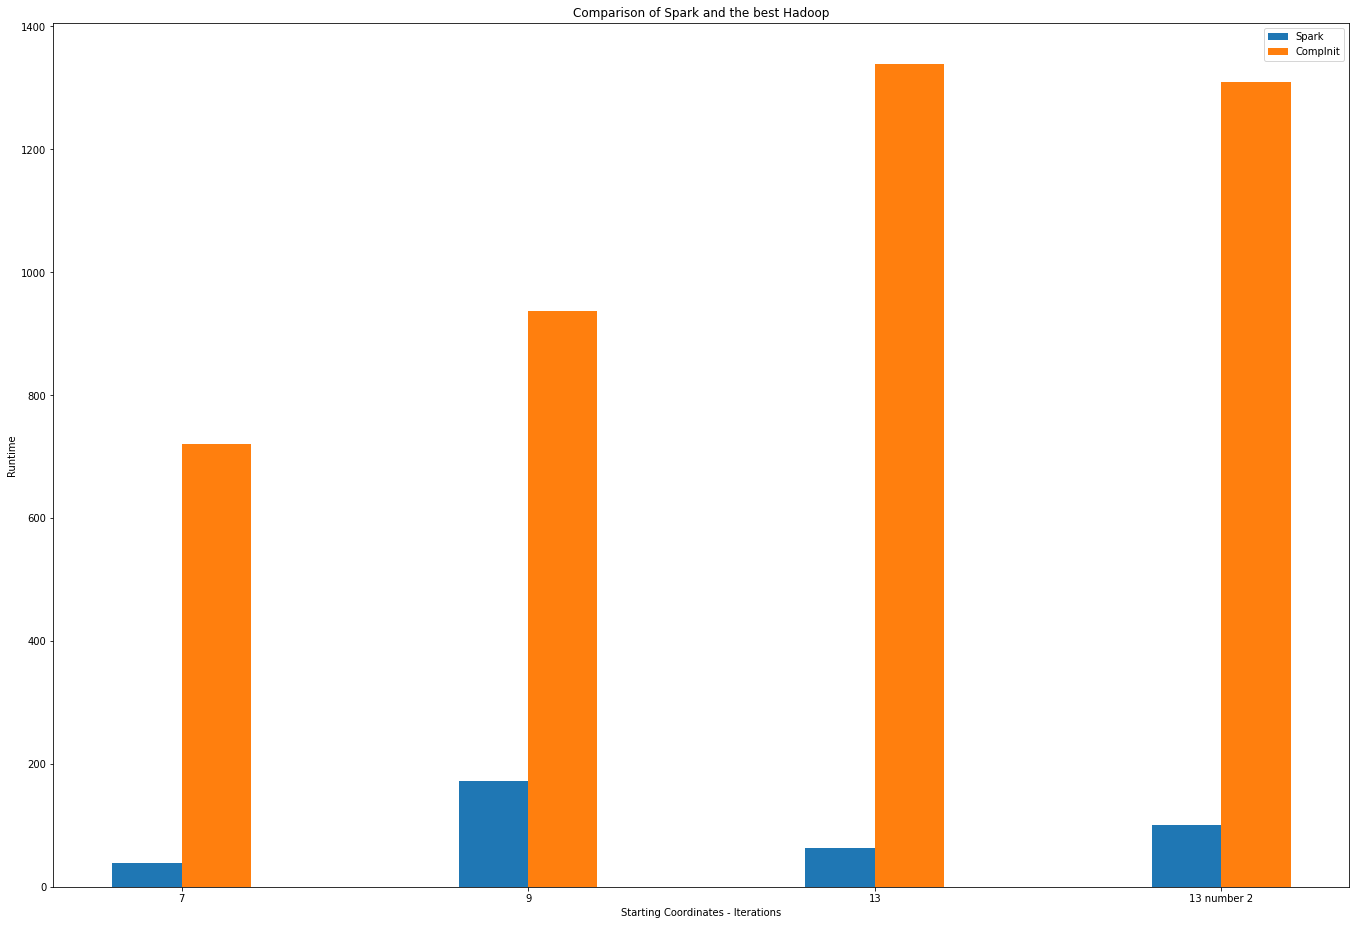

In [33]:
import numpy as np 
import matplotlib.pyplot as plt 

X = ["7", "9", "13", "13 number 2"]

Spark = [39, 172, 63, 101]
CompI = [721, 937, 1339, 1310]

# [,

fig = plt.figure()
X_axis = np.arange(len(X))
ax = fig.add_axes([0,0,3,3])
  
plt.bar(X_axis - 0.1, Spark, 0.2, label = 'Spark')
plt.bar(X_axis + 0.1, CompI, 0.2, label = 'CompInit')

  
plt.xticks(X_axis, X)
plt.xlabel("Starting Coordinates - Iterations")
plt.ylabel("Runtime")
plt.title("Comparison of Spark and the best Hadoop")
plt.legend()
plt.show()


In [ ]:
# Investigation